Processing BUS-UCLM-Dataset/data/partitions/test/images/FLKA_004.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ANFO_005.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ANFO_004.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/FLKA_005.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ANFO_006.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/COPE_018.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ANFO_007.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/FLKA_002.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ANFO_003.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ANFO_002.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/FLKA_003.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ELCO_008.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/ELCO_004.png...
Processing BUS-UCLM-Dataset/data/partitions/test/images/COPE_012

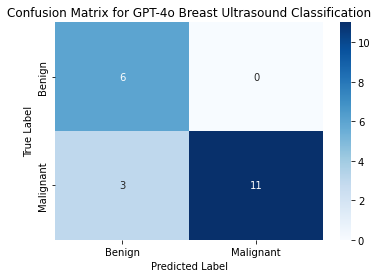

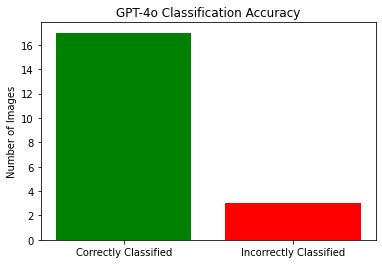

In [15]:
import json
import os
import openai
import base64
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define dataset paths
DATASET_DIR = "BUS-UCLM-Dataset"
DATA_FOLDER = os.path.join(DATASET_DIR, "data")
PARTITION_FOLDER = os.path.join(DATA_FOLDER, "partitions")
TEST_FOLDER = os.path.join(PARTITION_FOLDER, "test", "images")  
JSON_PATH = os.path.join(DATA_FOLDER, "test.json")

# OpenAI API Key
openai.api_key = "-"

# Define valid categories
CATEGORY_MAP = {1: "Benign", 2: "Malignant"}

def encode_image(image_path):
    """ Convert an image to base64 encoding for OpenAI Vision API. """
    if not os.path.exists(image_path):
        print(f"Warning: Missing image {image_path}")
        return None
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_ultrasound(image_path):
    """ Sends image to GPT-4o for classification. """
    image_base64 = encode_image(image_path)
    if image_base64 is None:
        return None

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": (
                    "You are an AI specializing in ultrasound image analysis. "
                    "Analyze the given breast ultrasound image and classify it strictly as either 'Benign' or 'Malignant'. "
                    "Consider shape, borders, and echogenicity. If the lesion has irregular borders, high echogenicity, and calcifications, it is likely Malignant. "
                    "Provide your analysis first, and at the very end, explicitly state the classification in this format:\n\n"
                    "Final Classification: [Benign/Malignant]\n\n"
                    "Do not provide medical advice—only describe visual features and provide the classification."
                )},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling GPT-4o API: {e}")
        return None

def extract_final_classification(analysis_report):
    """ Extracts the final classification from GPT-4o's response and standardizes it. """
    if not analysis_report:
        return "unknown"

    lines = analysis_report.strip().split("\n")
    for line in reversed(lines):
        line = line.strip().lower()
        if "final classification:" in line:
            pred_label = line.split("final classification:")[-1].strip()
            pred_label = re.sub(r"[^\w\s]", "", pred_label)  # Remove punctuation
            pred_label = pred_label.capitalize()  # Ensure first letter is uppercase

            # Ensure extracted label matches expected values
            if pred_label in CATEGORY_MAP.values():
                return pred_label
            else:
                print(f"Warning: Invalid classification '{pred_label}' from GPT-4o.")
    return "unknown"

# Load test.json
with open(JSON_PATH, "r") as f:
    data = json.load(f)

# Create image-to-label mapping
image_labels = {}
for annotation in data["annotations"]:
    image_id = annotation["image_id"]
    category_id = annotation["category_id"]
    image_labels[image_id] = CATEGORY_MAP[category_id]

# Extract image file names
image_paths = {}
for img in data["images"]:
    if img["id"] in image_labels:
        img_path = os.path.join(TEST_FOLDER, img["file_name"])
        if os.path.exists(img_path):
            image_paths[img["id"]] = img_path
        else:
            print(f"Warning: Missing image {img_path}")

# Process  the first 20 images
results = []
for img_id, img_path in list(image_paths.items())[:20]:  # Adjusted to process more images
    print(f"Processing {img_path}...")
    analysis_report = analyze_ultrasound(img_path)
    if analysis_report:
        predicted_label = extract_final_classification(analysis_report)
        true_label = image_labels[img_id]
        
        results.append({
            "image": img_path,
            "true_label": true_label,
            "predicted_label": predicted_label,
            "analysis": analysis_report
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print Formatted Output Like Your Other Codes
print("\nGPT-4o Classification Results:")
for _, row in results_df.iterrows():
    print(f"Filename: {row['image']}")
    print(f"True Label: {row['true_label']}")
    print(f"Predicted Label: {row['predicted_label']}")
    print(f"Analysis: {row['analysis']}")
    print("-" * 80)

# Prevent Errors if DataFrame is Empty
if results_df.empty:
    print("No valid images processed. Exiting early.")
else:
    results_df.to_csv("gpt4o_bus_uclm_results.csv", index=False)

    # Classification Report
    y_true = results_df['true_label']
    y_pred = results_df['predicted_label']

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=list(CATEGORY_MAP.values())))
    print("Accuracy:", accuracy_score(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(CATEGORY_MAP.values()))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(CATEGORY_MAP.values()), yticklabels=list(CATEGORY_MAP.values()))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GPT-4o Breast Ultrasound Classification")
    plt.show()

    # Bar Graph: Correct vs Incorrect Classifications
    correct_classifications = (y_true == y_pred).sum()
    incorrect_classifications = len(y_true) - correct_classifications

    plt.figure(figsize=(6, 4))
    plt.bar(["Correctly Classified", "Incorrectly Classified"], [correct_classifications, incorrect_classifications], color=['green', 'red'])
    plt.ylabel('Number of Images')
    plt.title('GPT-4o Classification Accuracy')
    plt.show()
